In [ ]:
from transformers import pipeline,  AutoProcessor, AutoModelForSeq2SeqLM, BlipProcessor, BlipForConditionalGeneration, Blip2Processor, Blip2ForConditionalGeneration 
import torch
import yaml
import requests
from PIL import Image
import os
import random
from ultralytics import YOLO
from utils.coco_utils.annotate_images import annotate_img

In [ ]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [ ]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")


In [ ]:
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
plane_image = Image.open('airplane_sample.png').convert('RGB')
single_plane_image = Image.open('individual_plane.png').convert('RGB')


In [ ]:
# conditional image captioning
#text = "a photography of"
text = "An image of a"
inputs = processor(single_plane_image, text, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor(single_plane_image, return_tensors="pt").to("cuda")

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "Salesforce/blip2-opt-2.7b"
processor = AutoProcessor.from_pretrained(MODEL_ID)
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
model = Blip2ForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=torch.float16)
model.to(device) 

#processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
#model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", device_map="auto")


In [ ]:

img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
plane_image = Image.open('airplane_sample.png').convert('RGB')
single_plane_image = Image.open('individual_plane.png').convert('RGB')
display(single_plane_image.resize((596, 437)))

In [ ]:
inputs = processor(plane_image, return_tensors="pt").to(device, torch.float16)
#max_new_tokens=40
generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)


In [ ]:
model_dir = f'E:/models'
model_path = f"{model_dir}/DOTA_dataset_512_yolov8m_bb_aug/weights/best.pt"
yolo_model = YOLO(model_path)
img_size = 512
device = 'cuda:0'

In [ ]:
prompt = "the image quality is"
prompt = "a photo of"
prompt = "I count"
prompt = "there are"
inputs = processor(plane_image, text=prompt, return_tensors="pt").to(device, torch.float16)
#max_new_tokens=40
generated_ids = model.generate(**inputs)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)


In [ ]:
def extract_region_with_buffer(image, xyxy_box, buffer=0):
    # Unpack the xyxy box
    x_min, y_min, x_max, y_max = xyxy_box
    
    # Add buffer
    x_min = max(x_min - buffer, 0)
    y_min = max(y_min - buffer, 0)
    x_max = min(x_max + buffer, image.width)
    y_max = min(y_max + buffer, image.height)
    
    # Crop the image
    cropped_image = image.crop((x_min, y_min, x_max, y_max))
    
    return cropped_image

In [ ]:
dataset_dir = f'E:/datasets'
dataset_name = f'DOTA_dataset_512'
image_paths = []

for tar_dir in [ 'val']:
    image_paths.extend([f'{dataset_dir}/{dataset_name}/{tar_dir}/images/{img_name}' for img_name in os.listdir(f'{dataset_dir}/{dataset_name}/{tar_dir}/images')])



In [ ]:
sample_size = 2
rimage_paths = random.sample(image_paths, sample_size)
rimage_paths

In [ ]:
for image_path in rimage_paths:
    #prompt = "The image quality is"
    prompt = "a picture of"
    #prompt = "There are"
    #prompt = "I count"
    #prompt = "there are"
    #prompt = 'From COCO classes I count'
    img =  Image.open(image_path).convert('RGB')
    inputs = processor(img, text=prompt, return_tensors="pt").to(device, torch.float16)
    #max_new_tokens=40
    generated_ids = model.generate(**inputs)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    print(generated_text)
    display(img)

In [ ]:
for image_path in rimage_paths:
    #prompt = "The image quality is"
    prompt = "a photo of"
    #prompt = "I count"
    #prompt = "there are"
    #prompt = 'From COCO classes I count'
    img =  Image.open(image_path).convert('RGB')
    inputs = processor(img, text=prompt, return_tensors="pt").to(device, torch.float16)
    #max_new_tokens=40
    generated_ids = model.generate(**inputs)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    print(generated_text)
    #display(img)
    results = yolo_model([img], imgsz=img_size, verbose=False, device=device)
    bboxes = []
    category_ids = []
    scores = []
    for result in results:
        result = result.to('cpu').numpy()
        boxes = result.boxes
        for box in boxes:
            cls_id = box.cls[0]
            print(f'{cls_id} | {box.conf[0]:.2f} | {box.xyxy[0]}')
            bboxes.append(box.xyxy[0])
            category_ids.append(cls_id)
            scores.append(int(round(box.conf[0]*100)))
            cimage = extract_region_with_buffer(img, box.xyxy[0], buffer=10)
            inputs = processor(cimage, text=prompt, return_tensors="pt").to(device, torch.float16)
            #max_new_tokens=40
            generated_ids = model.generate(**inputs)
            generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
            print(generated_text)
            display(cimage)
    
    img = annotate_img(img, bboxes, category_ids, scores=scores, category_id_to_name=None, 
                 colors_map=None, font_size=10, font_path=None, thickness=2,
                 bbox_format='xyxy')
    display(img)

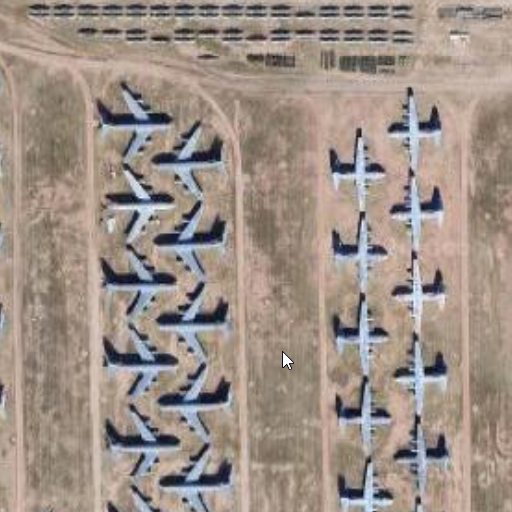

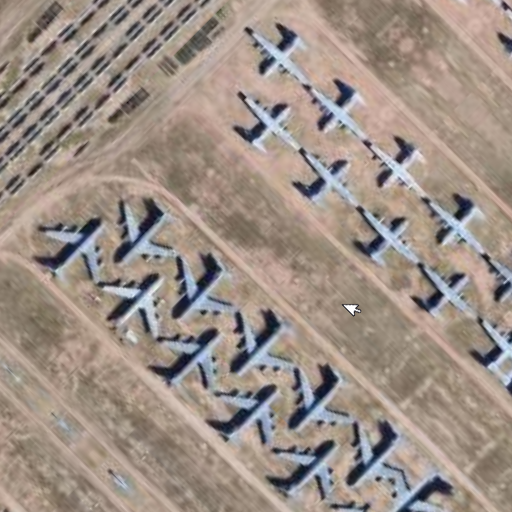

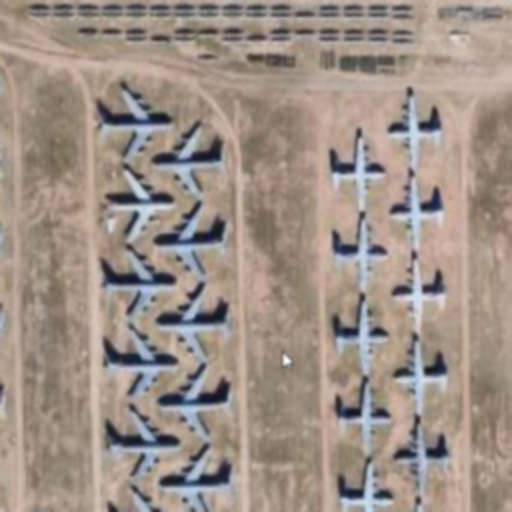

26214


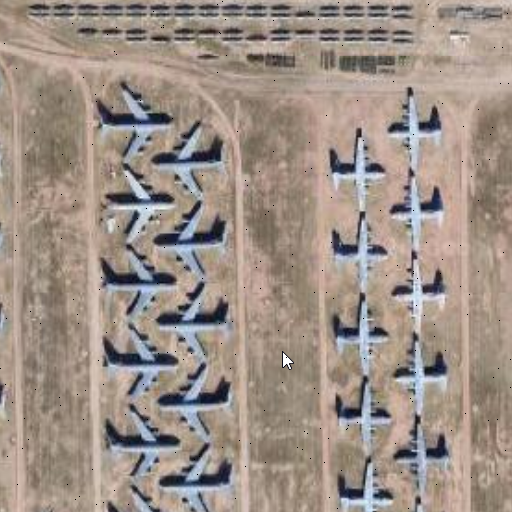

In [11]:
import albumentations as A
from PIL import Image
import numpy as np
import random
# Define augmentation functions
def rotate_image(image, angle):
    transform = A.Rotate(limit=(angle, angle), p=1.0)
    return transform(image=image)['image']

def gaussian_blur_image(image, sigma):
    transform = A.GaussianBlur(blur_limit=(sigma, sigma), p=1.0)
    return transform(image=image)['image']

def drop_pixels(image, drop_fraction=0.01):
    height, width, _ = image.shape
    num_pixels_to_drop = int(width * height * drop_fraction)
    
    for _ in range(num_pixels_to_drop):
        x = random.randint(0, width - 1)
        y = random.randint(0, height - 1)
        image[y, x] = [0, 0, 0]  # Drop to black or any other color
    
    return image

plane_image = Image.open('airplane_sample.png').convert('RGB')
display(plane_image)
image_np = np.array(plane_image)
aug_image = Image.fromarray(rotate_image(image_np, 45))
display(aug_image)
aug_image = Image.fromarray(gaussian_blur_image(image_np, 7))
display(aug_image)
print(int(512**2*0.1))
aug_image = Image.fromarray(drop_pixels(image_np, 0.001))
display(aug_image)